In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute, transpile
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
import qiskit.quantum_info as qi
from pydub import AudioSegment

In [2]:
#Reading the audio file
audio = AudioSegment.from_file('Cello.pizz.ff.sulC.C2.stereo.aif') 
#audio = audio.set_frame_rate(10000)
sample_rate = audio.frame_rate
data = audio.get_array_of_samples()[:]
N = len(data)
sample_rate

44100

In [3]:
N

321022

In [4]:
#Cropping the data to make N=2**n where n is number of qubits used to encode the audio in a quantum circuit

n_qubits = math.floor(np.log2(N))
data = data[:2**n_qubits]
N = len(data)                      #length of new data

In [5]:
t_hum = 1/10  #(in seconds)
Nmin = t_hum*sample_rate
Nwin = int(2**(math.ceil(np.log2(Nmin))-1))  #To make the algorithm 2**n
s = 4 #slide
Ns = math.floor((N-Nwin)/(Nwin/s))  #Number of windows

In [6]:
Ns

252

In [7]:
Nwin

4096

In [8]:
#window = np.ones(Nwin)
window = np.hamming(Nwin)
#window = np.hanning(Nwin)

## Quantum Fourier Transform

In [14]:
#Defining qft algorithm
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [17]:
#Each window corresponds to one quantum circuit with Nwin points.

circuits = []                      #To store all the circuits corresponding to windows
n_qubits = int(math.log2(Nwin))    #Number of qubits require to represent Nwin data points
#print(n_qubits)
for i in range(Ns-1):
    #print(i)
    my_data = (data[i*int(Nwin/s):(i*int(Nwin/s))+Nwin] * window)
    my_data = my_data/np.linalg.norm(my_data)

    #Encoding the data array on the quantum circuit by using 'qpam' method - which takes the input data, normalizes it and initializes on circuit of n qubits
    qr = QuantumRegister(n_qubits)
    qc = QuantumCircuit(qr)
    qc.initialize(my_data,qr[:])
    
    #Creating a circuit with quantum fourier transform alogithm
    qft_circuit = qft(n_qubits)

    #Merging both the initialized circuit and qft circuit 
    audio_qc = qc.compose(qft_circuit,list(np.arange(n_qubits)))
    circuits.append(audio_qc)

In [18]:
#Extracting the output vector of the each circuit (In this case fourier coeffiecients)
sv = []
for i in range(len(circuits)):
    sv0 = qi.Statevector.from_instruction(circuits[i]).to_dict()
    sv.append(sv0)

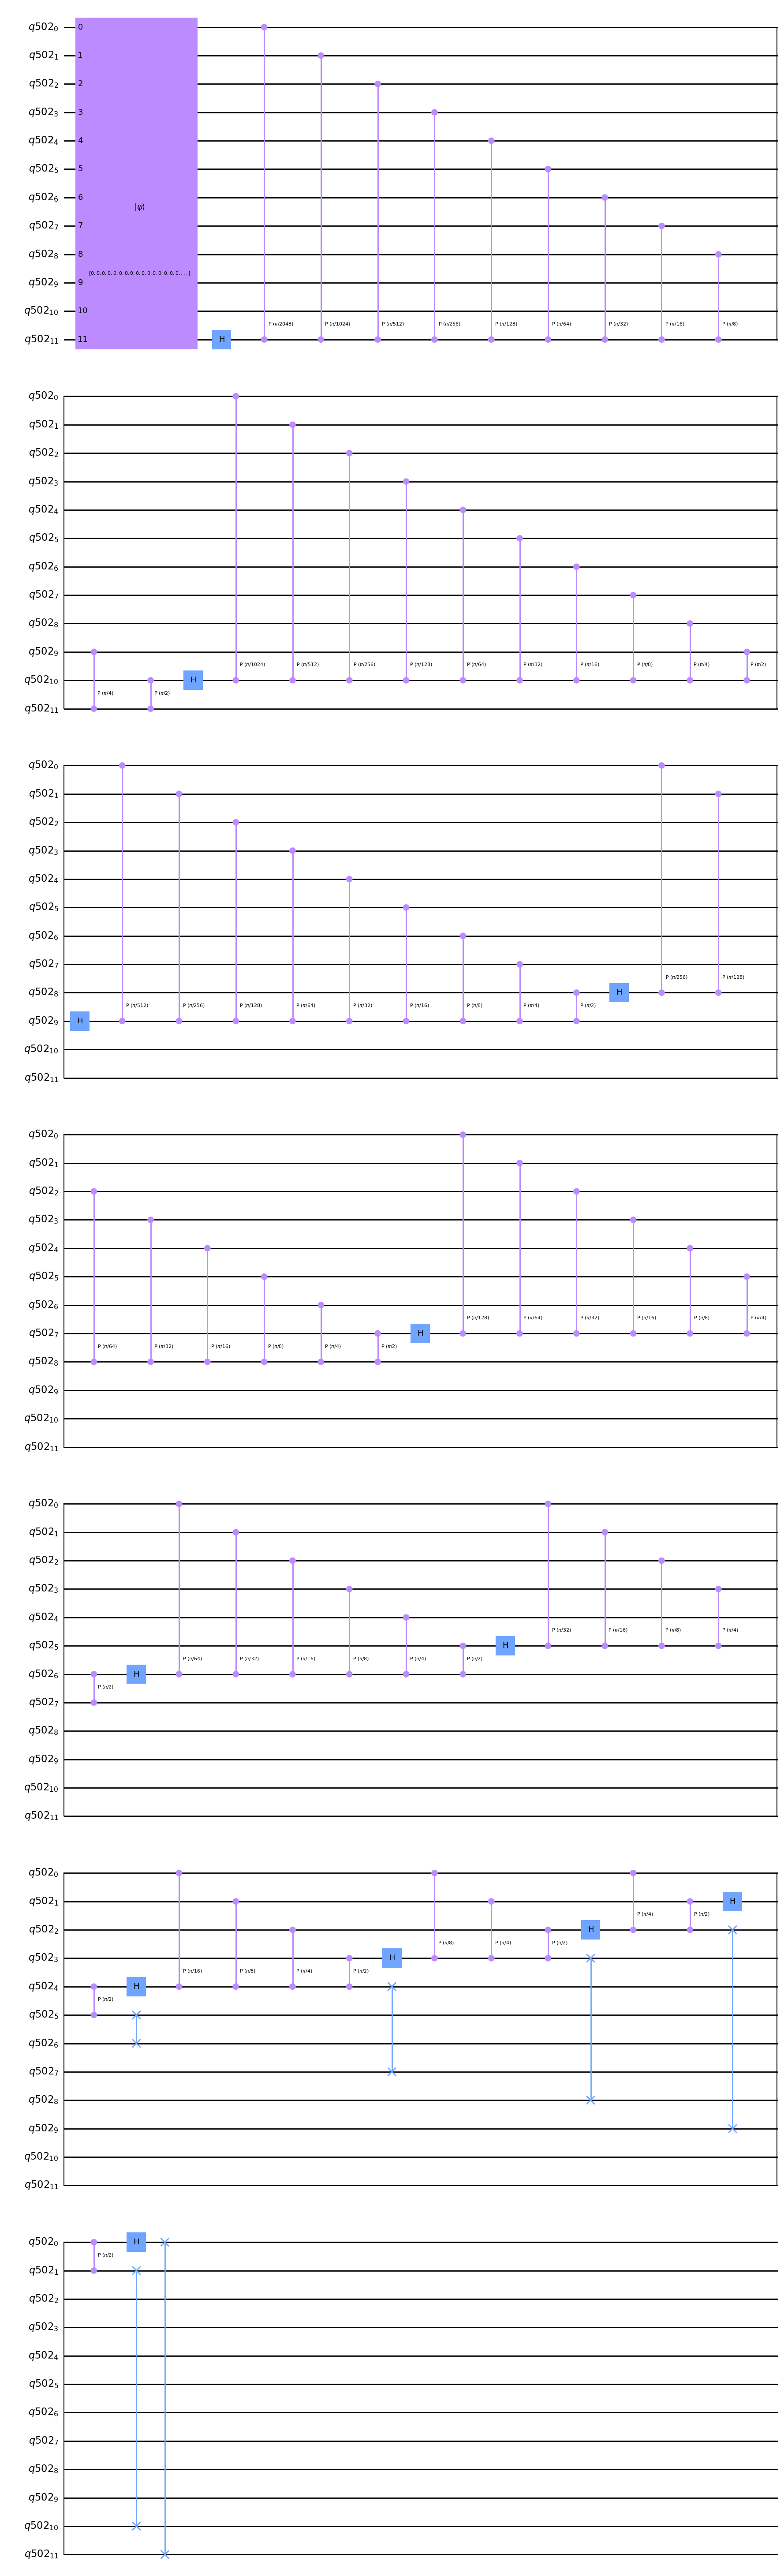

In [19]:
#Visualizing one of the circuit corresponding to a window
circuits[0].draw('mpl')

In [21]:
def get_fft_from_sv(sv, n_qubits):
    """Returns the counts in order of the digital value of the key which is the measured qbit state, i.e. in frequency order"""
    out = []
    keys = sv.keys()
    for i in range(2**n_qubits):
        id = get_bit_string(i, n_qubits)
        if(id in keys):
            out.append(sv[id])
        else:
            out.append(0)
    return out

def get_bit_string(n, n_qubits):
    """Returns the binary string of an integer with n_qubits characters"""
    assert n < 2**n_qubits, 'n too big to binarise, increase n_qubits or decrease n'
    bs = "{0:b}".format(n)
    bs = "0"*(n_qubits - len(bs)) + bs
    return bs

In [22]:
#Updating fourier coefficients as qft
qft = np.zeros([len(sv[0]),len(sv)],dtype=complex)
for i in range(len(sv)):
    qft[:,i] = get_fft_from_sv(sv[i],n_qubits)
N = len(qft)

In [23]:
np.shape(qft)

(4096, 251)

## Classical Fourier Transform

In [11]:
#Obtaining fourier spectogram classically
fft = np.zeros([Nwin,Ns],dtype=complex)
for i in range(Ns-1):
    my_data = (data[:][i*int(Nwin/s):(i*int(Nwin/s))+Nwin] * window)
    my_data = my_data/np.linalg.norm(my_data)
    fft[:,i] = np.fft.fft(my_data)

/tmp/ipykernel_2916/476894802.py:4: RuntimeWarning: divide by zero encountered in log
  pcm1 = axs[0].pcolorfast(10*np.log(np.abs(fft))) #log scale (in decibels)


Text(0.5, 1.0, 'Spectrogram using Quantum FT')

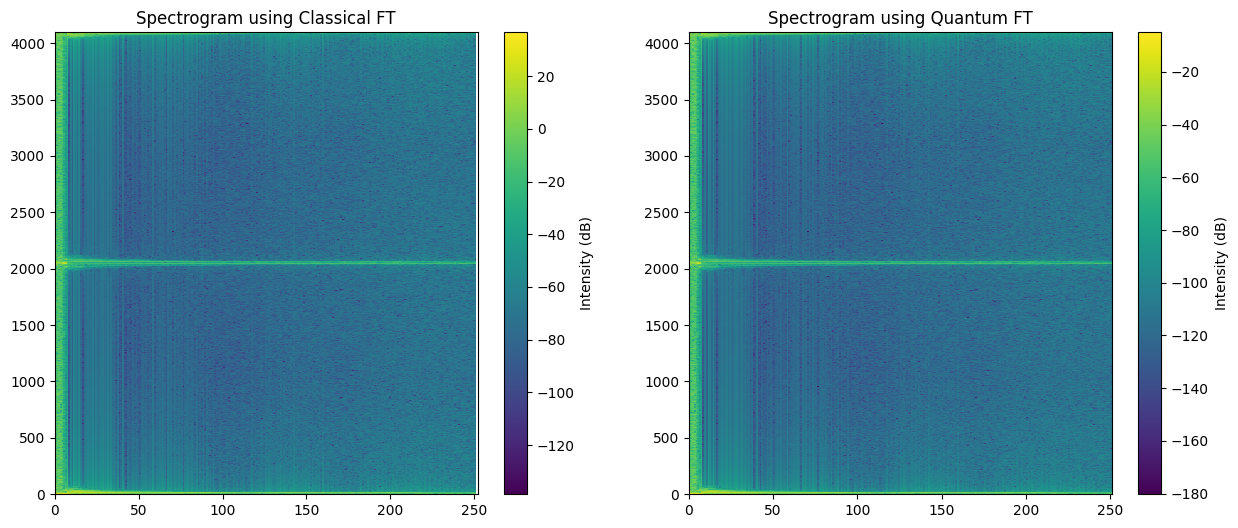

In [25]:
#Comparing spectogram from both
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plotting the first graph
pcm1 = axs[0].pcolorfast(10*np.log(np.abs(fft))) #log scale (in decibels)

# Plotting the second graph
pcm2 = axs[1].pcolorfast(10*np.log(np.abs(qft))) #log scale (in decibels)

# Add colorbars for each subplot
fig.colorbar(pcm1, ax=axs[0], label='Intensity (dB)')
fig.colorbar(pcm2, ax=axs[1], label='Intensity (dB)')

# Set titles and labels
axs[0].set_title('Spectrogram using Classical FT')
axs[1].set_title('Spectrogram using Quantum FT')

/tmp/ipykernel_2916/30336899.py:7: RuntimeWarning: divide by zero encountered in log
  pcm1 = axs[0].pcolorfast(times,freqs,10*np.log(np.abs(fft)),vmin=-80) #log scale (in decibels)


(0.0, 1000.0)

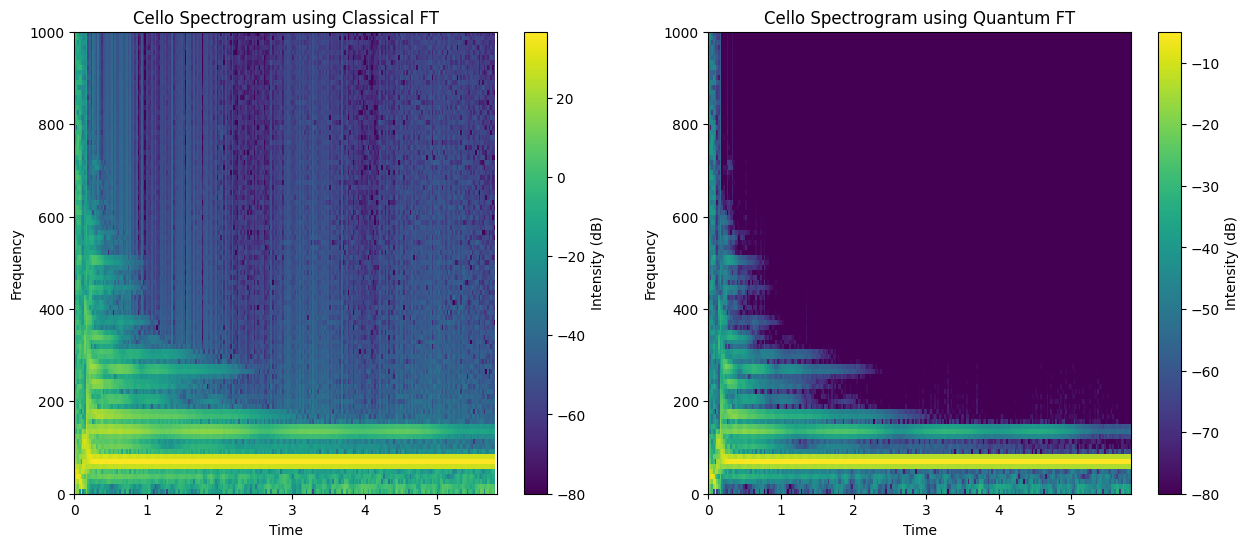

In [35]:
freqs = np.arange(Nwin)*sample_rate/Nwin
times = np.arange(Ns)*Nwin/(s*sample_rate)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plotting the first graph
pcm1 = axs[0].pcolorfast(times,freqs,10*np.log(np.abs(fft)),vmin=-80) #log scale (in decibels)

# Plotting the second graph
pcm2 = axs[1].pcolorfast(times,freqs,10*np.log(np.abs(qft)),vmin=-80) #log scale (in decibels)

# Add colorbars for each subplot
fig.colorbar(pcm1, ax=axs[0], label='Intensity (dB)')
fig.colorbar(pcm2, ax=axs[1], label='Intensity (dB)')

# Set titles and labels
axs[0].set_title('Cello Spectrogram using Classical FT')
axs[1].set_title('Cello Spectrogram using Quantum FT')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Frequency')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Frequency')

axs[0].set_ylim(0,1000)
axs[1].set_ylim(0,1000)